# Bayesian Cross Sectional Models

This notebook investigates the fit and parameter estimates of Bayesian models. We try the following three distributions:
- Pareto
- Weibull
- Generalised Pareto

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import dill
import os

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Self made modules
from thesis_tools.utils.data import *
from thesis_tools.utils.model_fitting import *
from thesis_tools.statistical_tests.tests import *
from thesis_tools.models.bayesian_univariate_cross_sectional import *
from thesis_tools.models.bayesian_multivariate_cross_sectional import *

## Estimation

In [4]:
df = read_panel_data(observations_threshold=20)
len(df)

250

In [5]:
# find all combinations of group and year
groups = df['group'].unique()
for group in groups:
    years = df[df['group'] == group]['year'].unique()
    for year in years:
        for model_type in ['Pareto', 'Weibull', 'GeneralisedPareto']:
            train_or_retrieve_cross_sectional_model(df, group, year, model_type, retrain_if_saved=False)
            print(f"Trained model for {group} in {year} using {model_type} distribution")

Trained model for Alps in 2013 using Pareto distribution
Trained model for Alps in 2013 using Weibull distribution
Trained model for Alps in 2013 using GeneralisedPareto distribution
Trained model for Alps in 2014 using Pareto distribution
Trained model for Alps in 2014 using Weibull distribution
Trained model for Alps in 2014 using GeneralisedPareto distribution
Trained model for Alps in 2015 using Pareto distribution
Trained model for Alps in 2015 using Weibull distribution
Trained model for Alps in 2015 using GeneralisedPareto distribution
Trained model for Alps in 2016 using Pareto distribution
Trained model for Alps in 2016 using Weibull distribution
Trained model for Alps in 2016 using GeneralisedPareto distribution
Trained model for Alps in 2017 using Pareto distribution
Trained model for Alps in 2017 using Weibull distribution
Trained model for Alps in 2017 using GeneralisedPareto distribution
Trained model for Alps in 2018 using Pareto distribution
Trained model for Alps in 20

## Evaluation

### Prior Predictive Checks

### Fit

We evaluate the fit similarly to the way we evaluated the fit for frequentist models:
- Kolmogorov-Smirnof Test
- Anderson-Darling Test
- Cramer- von Mises Test

In [6]:
path = "../../Stored_Results/bayesian_cross_sectional/test_df.pkl"
rebuild = False
if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        test_df = dill.load(f)
else:
    test_dict = {}
    ks_stat_list = []
    ks_pval_list = []
    cm_stat_list = []
    ad_stat_list = []
    years = df['year'].unique()
    for year in years:
        groups = df[df['year'] == year]['group'].unique()
        # if year != 2018: # Only 2018 for now
        #     continue
        for group in groups:
            for model_type in ['Pareto', 'Weibull', 'GeneralisedPareto']:
                print(f"Testing {group} in {year} using {model_type} distribution")
                model = train_or_retrieve_cross_sectional_model(df, group, year, model_type=model_type)
                post_pred = model.posterior_predictive(progressbar=False)['y']
                true_data = np.array(df[(df['group'] == group) & (df['year'] == year)]['net_worth'].values[0])
                ks_stat, ks_pval = Kolmogorov_Smirnov_two_sample_test(data1=post_pred, data2=true_data)
                _, cm_stat = Anderson_Darling_statistic(data_1=post_pred, data_2=true_data, weight_function='Cramer-von Mises')
                _, ad_stat = Anderson_Darling_statistic(data_1=post_pred, data_2=true_data, weight_function='Anderson-Darling')
                test_dict[(year, group, model_type)] = {'KS_stat': ks_stat, 'KS_pval': ks_pval, 'CM_stat': cm_stat, 'AD_stat': ad_stat}
                ks_stat_list.append(ks_stat)
                ks_pval_list.append(ks_pval)
                cm_stat_list.append(cm_stat)
                ad_stat_list.append(ad_stat)
    test_df = pd.DataFrame(test_dict).T
    test_df.index.names = ['year', 'group', 'model_type']
    with open(path, 'wb') as f:
        dill.dump(test_df, f)

In [7]:
path = "../../Stored_Results/bayesian_cross_sectional/test_df.pkl"
with open(path, 'wb') as f:
    dill.dump(test_df, f)

In [8]:
if os.path.exists(path):
    with open(path, 'rb') as f:
        test_df = dill.load(f)

In [9]:
test_df

KS_stat   KS_pval   CM_stat  \
year group         model_type                                        
2013 Alps          Pareto             0.245012  0.135191  0.001751   
                   Weibull            0.154202  0.644886  0.027604   
                   GeneralisedPareto  0.166964  0.546486  0.001057   
     Asian Islands Pareto             0.099024  0.544333  0.001048   
                   Weibull            0.162371  0.067709  0.014421   
...                                        ...       ...       ...   
2001 U.S.          Weibull            0.080470  0.179276  0.017918   
                   GeneralisedPareto  0.076923  0.220128  0.000168   
2002 U.S.          Pareto             0.085227  0.146335  0.000053   
                   Weibull            0.106979  0.032975  0.013383   
                   GeneralisedPareto  0.085227  0.146335  0.000009   

                                           AD_stat  
year group         model_type                       
2013 Alps          Pareto             1.750581e+06  
                   Weibull            8.273642e+05  
                   GeneralisedPareto  1.057228e+06  
     Asian Islands Pareto             1.048072e+06  
                   Weibull            3.697960e+04  
...                                            ...  
2001 U.S.          Weibull            1.129848e+03  
                   GeneralisedPareto  1.681080e+05  
2002 U.S.          Pareto             5.269583e+04  
                   Weibull            1.104712e+03  
                   GeneralisedPareto  8.694074e+03  

[750 rows x 4 columns]

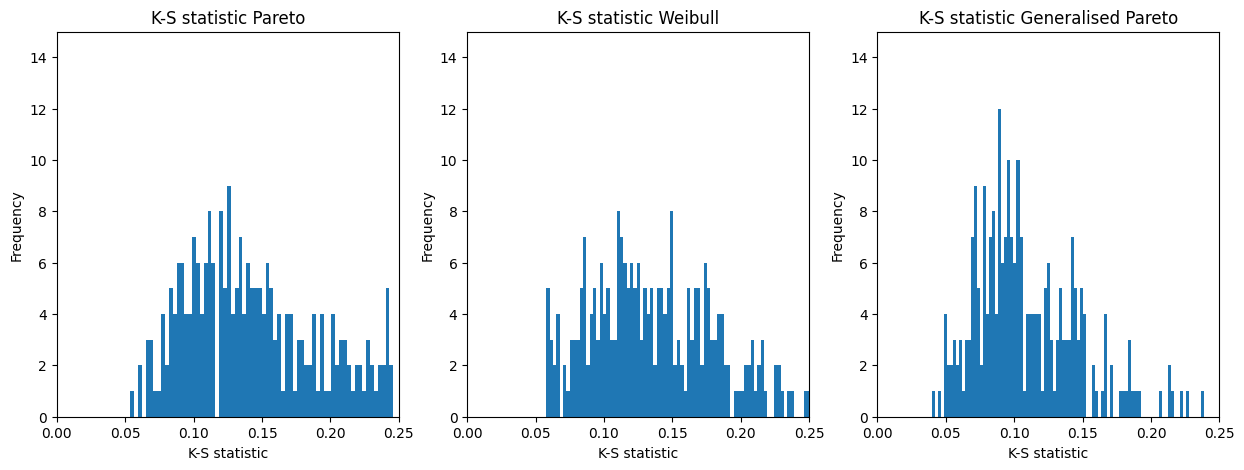

In [10]:
# Plot the K-S stats for the 3 distributions next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 0.25
y_lb, y_ub = 0, 15
n_bins = 100
ax[0].hist(test_df.xs('Pareto', level='model_type')['KS_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('K-S statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('K-S statistic Pareto')
ax[1].hist(test_df.xs('Weibull', level='model_type')['KS_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('K-S statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('K-S statistic Weibull')
ax[2].hist(test_df.xs('GeneralisedPareto', level='model_type')['KS_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('K-S statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('K-S statistic Generalised Pareto')
plt.show()


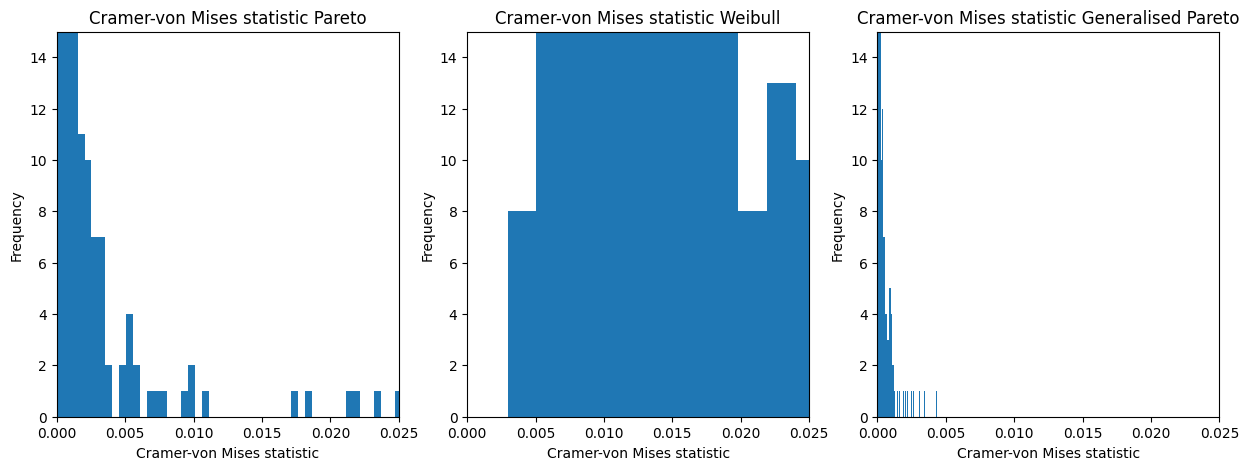

In [11]:
# Do the same for the Cramer-von Mises statistic
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 0.025
y_lb, y_ub = 0, 15
n_bins = 50
ax[0].hist(test_df.xs('Pareto', level='model_type')['CM_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('Cramer-von Mises statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Cramer-von Mises statistic Pareto')
ax[1].hist(test_df.xs('Weibull', level='model_type')['CM_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('Cramer-von Mises statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Cramer-von Mises statistic Weibull')
ax[2].hist(test_df.xs('GeneralisedPareto', level='model_type')['CM_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('Cramer-von Mises statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Cramer-von Mises statistic Generalised Pareto')
plt.show()

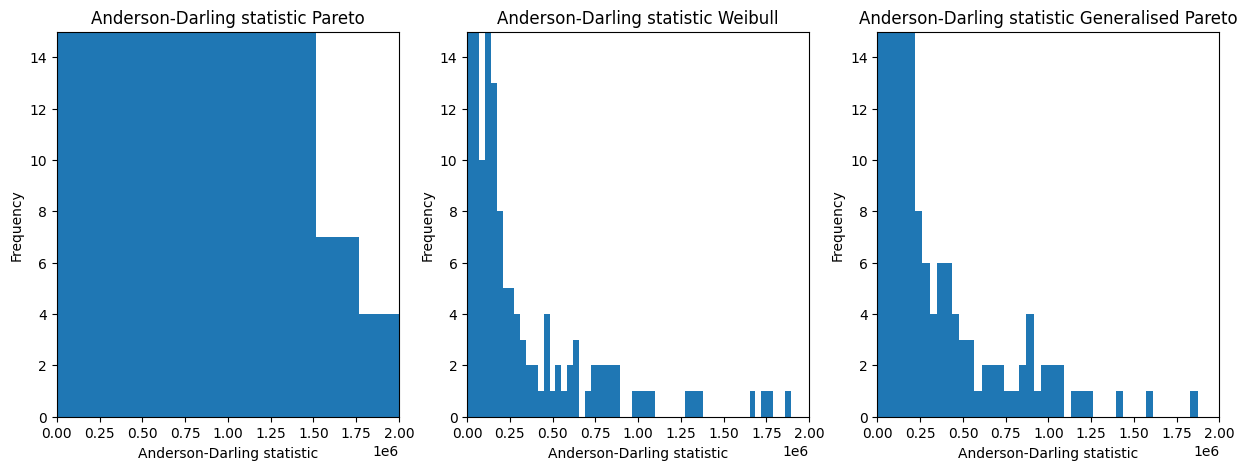

In [12]:
# Do the same for the Anderson-Darling statistic
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
x_lb, x_ub = 0.00, 2e6
y_lb, y_ub = 0, 15
n_bins = 100
ax[0].hist(test_df.xs('Pareto', level='model_type')['AD_stat'], bins=n_bins)
ax[0].set_xlim(x_lb, x_ub)
ax[0].set_ylim(y_lb, y_ub)
ax[0].set_xlabel('Anderson-Darling statistic')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Anderson-Darling statistic Pareto')
ax[1].hist(test_df.xs('Weibull', level='model_type')['AD_stat'], bins=n_bins)
ax[1].set_xlim(x_lb, x_ub)
ax[1].set_ylim(y_lb, y_ub)
ax[1].set_xlabel('Anderson-Darling statistic')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Anderson-Darling statistic Weibull')
ax[2].hist(test_df.xs('GeneralisedPareto', level='model_type')['AD_stat'], bins=n_bins)
ax[2].set_xlim(x_lb, x_ub)
ax[2].set_ylim(y_lb, y_ub)
ax[2].set_xlabel('Anderson-Darling statistic')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Anderson-Darling statistic Generalised Pareto')
plt.show()

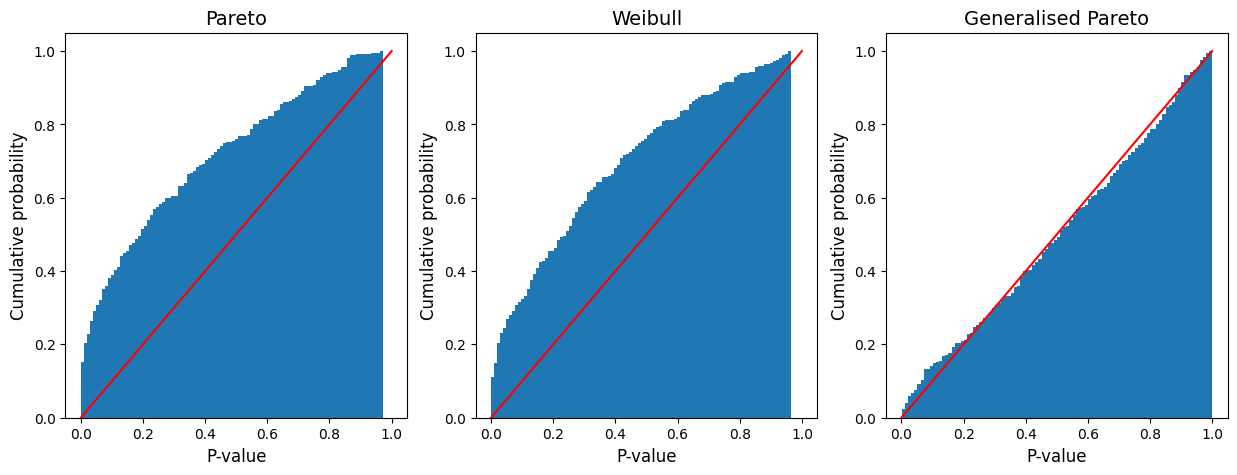

In [13]:
# Compare how often the null hypothesis is rejected for the 3 distributions
# Find the empirical distribution of the p-values for the 3 distributions
pareto_pvals = test_df.xs('Pareto', level='model_type')['KS_pval']
weibull_pvals = test_df.xs('Weibull', level='model_type')['KS_pval']
generalised_pareto_pvals = test_df.xs('GeneralisedPareto', level='model_type')['KS_pval']

# Plot the empirical cumulative distribution function of the p-values
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n_bins = 100
ax[0].hist(pareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[0].plot(x, x, color='red')
ax[0].set_xlabel('P-value', fontsize=12)
ax[0].set_ylabel('Cumulative probability', fontsize=12)
ax[0].set_title('Pareto', fontsize=14)
ax[1].hist(weibull_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[1].plot(x, x, color='red')
ax[1].set_xlabel('P-value', fontsize=12)
ax[1].set_ylabel('Cumulative probability', fontsize=12)
ax[1].set_title('Weibull', fontsize=14)
ax[2].hist(generalised_pareto_pvals, bins=n_bins, cumulative=True, density=True)
x = np.linspace(0, 1, 100)
ax[2].plot(x, x, color='red')
ax[2].set_xlabel('P-value', fontsize=12)
ax[2].set_ylabel('Cumulative probability', fontsize=12)
ax[2].set_title('Generalised Pareto', fontsize=14)
plt.show()



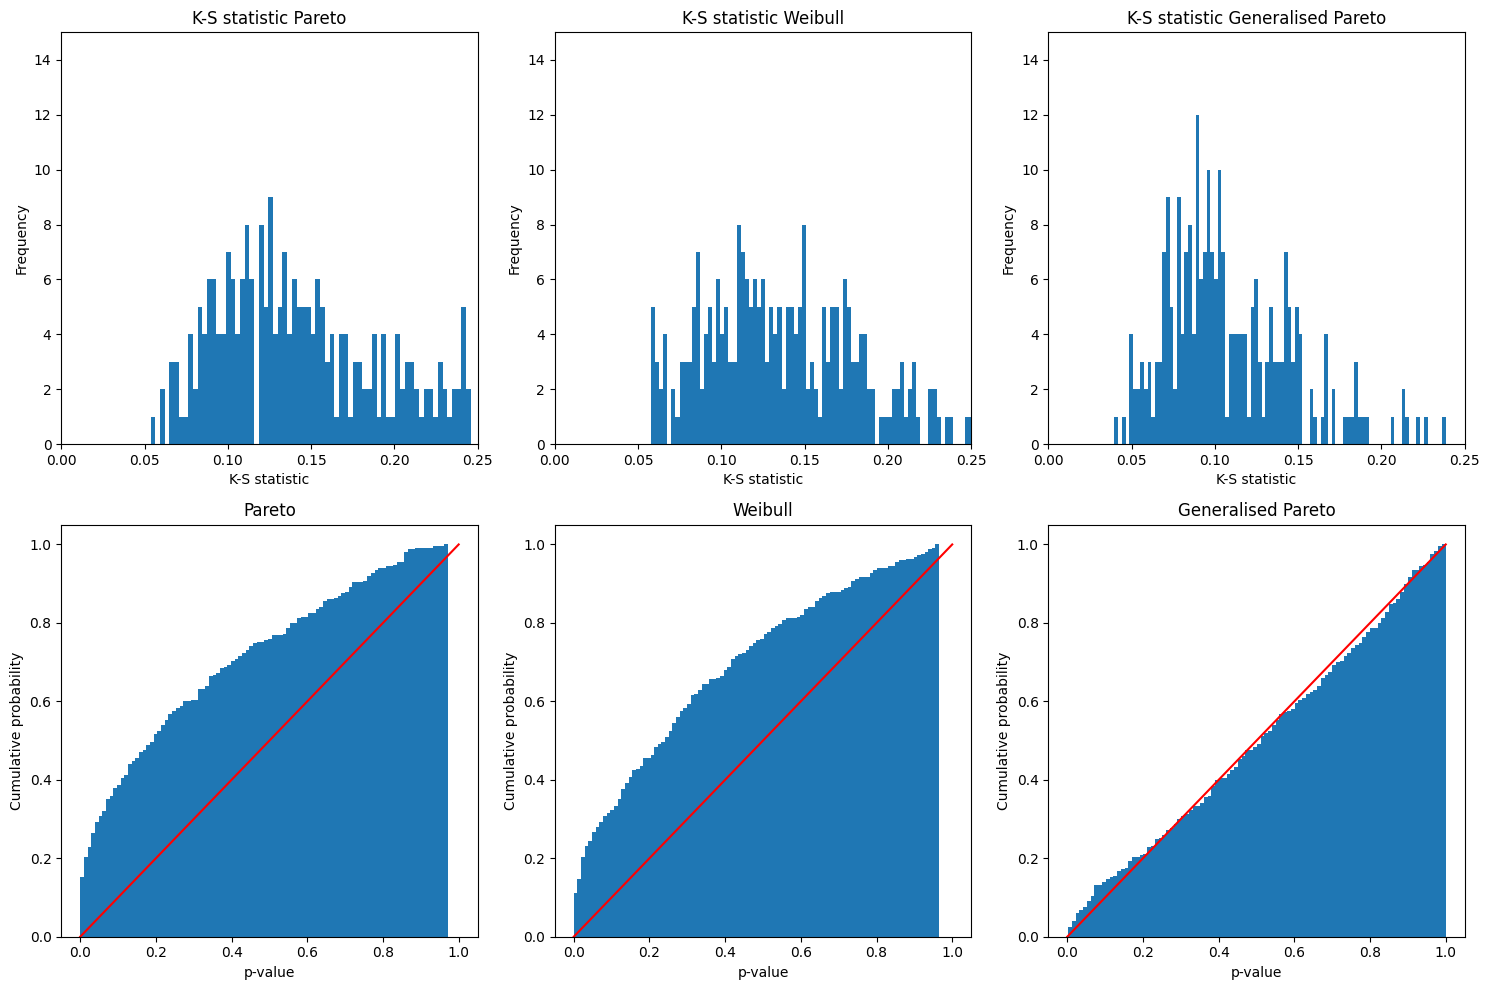

In [14]:
# Set up a 2x3 grid for the subplots
fig, ax = plt.subplots(2, 3, figsize=(15, 10))  # Adjust the height to accommodate both rows

# Define common plot settings
x_lb, x_ub = 0.00, 0.25
y_lb, y_ub = 0, 15
n_bins = 100
x_pval = np.linspace(0, 1, 100)

# Plot the K-S statistics
ax[0, 0].hist(test_df.xs('Pareto', level='model_type')['KS_stat'], bins=n_bins)
ax[0, 0].set_xlim(x_lb, x_ub)
ax[0, 0].set_ylim(y_lb, y_ub)
ax[0, 0].set_xlabel('K-S statistic')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].set_title('K-S statistic Pareto')

ax[0, 1].hist(test_df.xs('Weibull', level='model_type')['KS_stat'], bins=n_bins)
ax[0, 1].set_xlim(x_lb, x_ub)
ax[0, 1].set_ylim(y_lb, y_ub)
ax[0, 1].set_xlabel('K-S statistic')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].set_title('K-S statistic Weibull')

ax[0, 2].hist(test_df.xs('GeneralisedPareto', level='model_type')['KS_stat'], bins=n_bins)
ax[0, 2].set_xlim(x_lb, x_ub)
ax[0, 2].set_ylim(y_lb, y_ub)
ax[0, 2].set_xlabel('K-S statistic')
ax[0, 2].set_ylabel('Frequency')
ax[0, 2].set_title('K-S statistic Generalised Pareto')

# Plot the empirical cumulative distribution function of the p-values
pareto_pvals = test_df.xs('Pareto', level='model_type')['KS_pval']
weibull_pvals = test_df.xs('Weibull', level='model_type')['KS_pval']
generalised_pareto_pvals = test_df.xs('GeneralisedPareto', level='model_type')['KS_pval']

ax[1, 0].hist(pareto_pvals, bins=n_bins, cumulative=True, density=True)
ax[1, 0].plot(x_pval, x_pval, color='red')
ax[1, 0].set_xlabel('p-value')
ax[1, 0].set_ylabel('Cumulative probability')
ax[1, 0].set_title('Pareto')

ax[1, 1].hist(weibull_pvals, bins=n_bins, cumulative=True, density=True)
ax[1, 1].plot(x_pval, x_pval, color='red')
ax[1, 1].set_xlabel('p-value')
ax[1, 1].set_ylabel('Cumulative probability')
ax[1, 1].set_title('Weibull')

ax[1, 2].hist(generalised_pareto_pvals, bins=n_bins, cumulative=True, density=True)
ax[1, 2].plot(x_pval, x_pval, color='red')
ax[1, 2].set_xlabel('p-value')
ax[1, 2].set_ylabel('Cumulative probability')
ax[1, 2].set_title('Generalised Pareto')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Mean wealth prediction

In [15]:
path = "../../Stored_Results/bayesian_cross_sectional/mean_wealth_df.pkl"
rebuild = False
if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        mean_wealth_df = dill.load(f)
else:
    mean_wealth = {}
    years = df['year'].unique()
    for year in years:
        groups = df[df['year'] == year]['group'].unique()
        # if year != 2018: # Only 2018 for now
        #     continue
        for group in groups:
            print(f"Calculating mean wealth for {group} in {year}")
            for model_type in ['Pareto', 'Weibull', 'GeneralisedPareto']:
                model = train_or_retrieve_cross_sectional_model(df, group, year, model_type=model_type)
                post_pred = model.posterior_predictive(progressbar=False)
                mean_data = np.array(df[(df['year'] == year) & (df['group'] == group)]['net_worth'].iloc[0]).mean()
                mean_wealth[(year, group, model_type)] = {
                    'mean_data': mean_data,
                    'mean_model': post_pred['y'].mean(),
                    'resid': mean_data - post_pred['y'].mean(),
                    'abs_resid': np.abs(mean_data - post_pred['y'].mean()),
                    'squared_resid': (mean_data - post_pred['y'].mean())**2
                }
    mean_wealth_df = pd.DataFrame(mean_wealth).T
    mean_wealth_df.index.names = ['year', 'group', 'model_type']
    with open(path, 'wb') as f:
        dill.dump(mean_wealth_df, f)

In [16]:
mean_wealth_df

mean_data  mean_model       resid  \
year group         model_type                                             
2013 Alps          Pareto              3.657143  494.873963 -491.216820   
                   Weibull             3.657143    3.639172    0.017971   
                   GeneralisedPareto   3.657143    5.395124   -1.737981   
     Asian Islands Pareto              2.708065    7.591789   -4.883725   
                   Weibull             2.708065    2.714133   -0.006069   
...                                         ...         ...         ...   
2001 U.S.          Weibull             3.818681    3.516005    0.302676   
                   GeneralisedPareto   3.818681    4.778176   -0.959495   
2002 U.S.          Pareto              3.571591    7.336096   -3.764505   
                   Weibull             3.571591    3.230864    0.340727   
                   GeneralisedPareto   3.571591    4.744983   -1.173392   

                                       abs_resid  squared_resid  
year group         model_type                                    
2013 Alps          Pareto             491.216820  241293.964132  
                   Weibull              0.017971       0.000323  
                   GeneralisedPareto    1.737981       3.020577  
     Asian Islands Pareto               4.883725      23.850768  
                   Weibull              0.006069       0.000037  
...                                          ...            ...  
2001 U.S.          Weibull              0.302676       0.091613  
                   GeneralisedPareto    0.959495       0.920631  
2002 U.S.          Pareto               3.764505      14.171498  
                   Weibull              0.340727       0.116095  
                   GeneralisedPareto    1.173392       1.376848  

[750 rows x 5 columns]

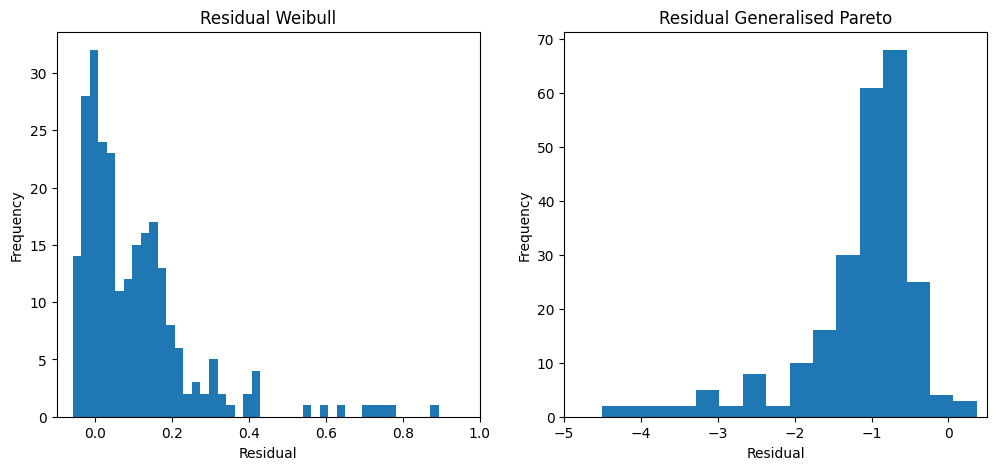

In [17]:
# Plot the residuals for the 3 distributions
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
n_bins = 100
ax[0].hist(mean_wealth_df.xs('Weibull', level='model_type')['resid'], bins=n_bins)
ax[0].set_xlim(-0.1, 1.0)
ax[0].set_xlabel('Residual')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Residual Weibull')
ax[1].hist(mean_wealth_df.xs('GeneralisedPareto', level='model_type')['resid'], bins=n_bins)
ax[1].set_xlim(-5, 0.5)
ax[1].set_xlabel('Residual')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Residual Generalised Pareto')
plt.show()

In [18]:
# # Plot the residuals for the 3 distributions
# fig, ax = plt.subplots(1, 3, figsize=(15, 5))
# n_bins = 100
# ax[0].hist(mean_wealth_df.xs('Pareto', level='model_type')['resid'], bins=n_bins)
# ax[0].set_xlim(-1000, -10)
# ax[0].set_xlabel('Residual')
# ax[0].set_ylabel('Frequency')
# ax[0].set_title('Residual Pareto')
# ax[1].hist(mean_wealth_df.xs('Weibull', level='model_type')['resid'], bins=n_bins)
# ax[1].set_xlim(-0.1, 1.0)
# ax[1].set_xlabel('Residual')
# ax[1].set_ylabel('Frequency')
# ax[1].set_title('Residual Weibull')
# ax[2].hist(mean_wealth_df.xs('GeneralisedPareto', level='model_type')['resid'], bins=n_bins)
# ax[2].set_xlim(-5, 0.5)
# ax[2].set_xlabel('Residual')
# ax[2].set_ylabel('Frequency')
# ax[2].set_title('Residual Generalised Pareto')
# plt.show()

In [19]:
# find the average absolute residuals by country/distribution:
without_pareto = mean_wealth_df[mean_wealth_df.index.get_level_values('model_type') != 'Pareto']
grouped_mean_wealth = without_pareto.groupby(['group', 'model_type']).mean()

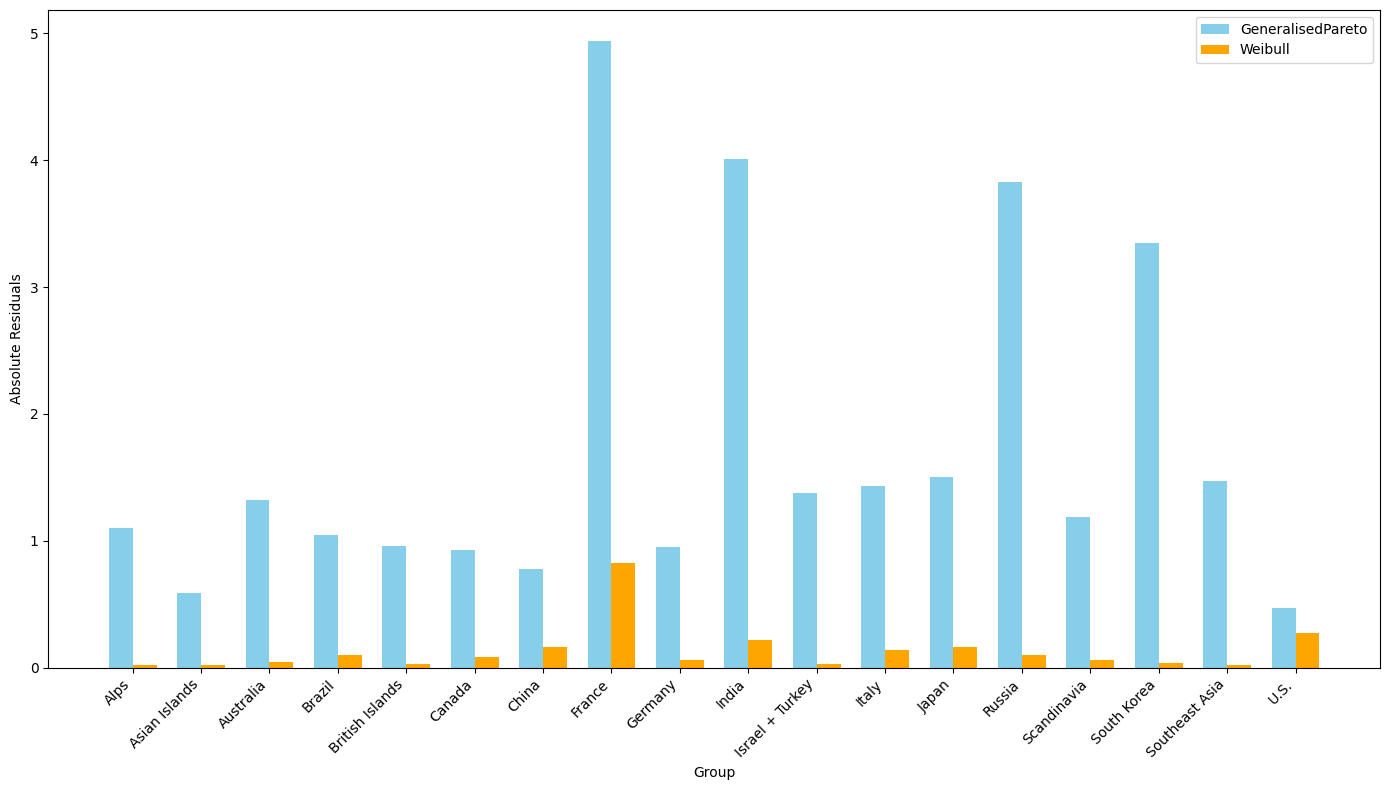

In [20]:
# Plotting the bar plot for abs_resid column
fig, ax = plt.subplots(figsize=(14, 8))

# Extract data for plotting
groups = grouped_mean_wealth.index.get_level_values('group').unique()
x = np.arange(len(groups))  # the label locations
width = 0.35  # the width of the bars

# Data for bars
generalised_pareto_resid = grouped_mean_wealth.xs('GeneralisedPareto', level='model_type')['abs_resid']
weibull_resid = grouped_mean_wealth.xs('Weibull', level='model_type')['abs_resid']

# Plot bars
rects1 = ax.bar(x - width/2, generalised_pareto_resid, width, label='GeneralisedPareto', color='skyblue')
rects2 = ax.bar(x + width/2, weibull_resid, width, label='Weibull', color='orange')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Group')
ax.set_ylabel('Absolute Residuals')
# ax.set_title('Absolute Residuals by Group and Model Type')
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha="right")
ax.legend()

fig.tight_layout()

# Display the plot
plt.show()

In [21]:
grouped_by_year_mean_wealth = without_pareto.groupby(['year', 'model_type']).median()

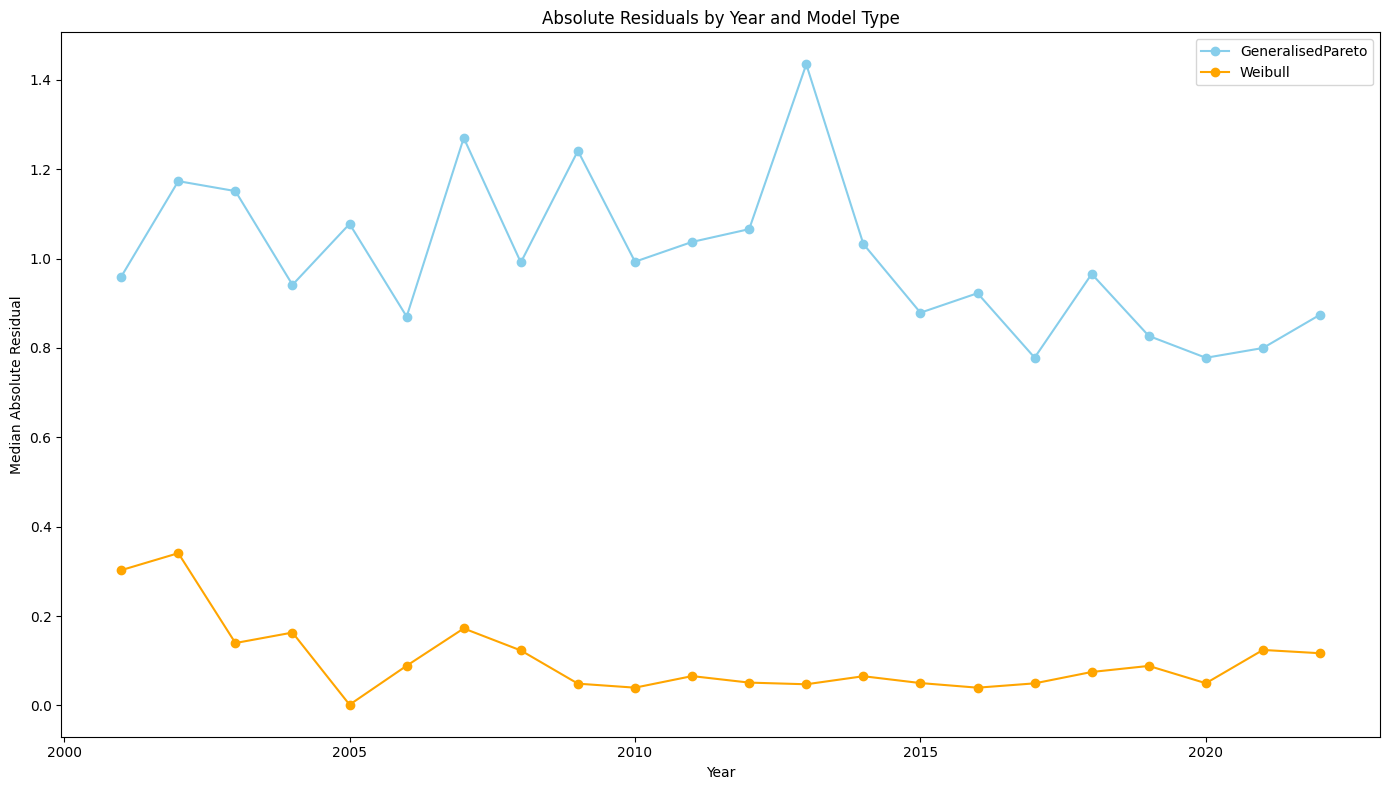

In [22]:
# Plotting the line plot for abs_resid column
fig, ax = plt.subplots(figsize=(14, 8))

# Extract data for plotting
years = grouped_by_year_mean_wealth.index.get_level_values('year').unique()

# Data for lines
generalised_pareto_resid = grouped_by_year_mean_wealth.xs('GeneralisedPareto', level='model_type')['abs_resid']
weibull_resid = grouped_by_year_mean_wealth.xs('Weibull', level='model_type')['abs_resid']

# Plot lines
ax.plot(years, generalised_pareto_resid, label='GeneralisedPareto', color='skyblue', marker='o')
ax.plot(years, weibull_resid, label='Weibull', color='orange', marker='o')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Year')
ax.set_ylabel('Median Absolute Residual')
ax.set_title('Absolute Residuals by Year and Model Type')
ax.legend()

fig.tight_layout()

# Display the plot
plt.show()

### Compare coefficients across time

In [23]:
path = "../../Stored_Results/bayesian_cross_sectional/coefficient_df.pkl"
rebuild = False
if os.path.exists(path) and not rebuild:
    with open(path, 'rb') as f:
        coefficient_df = dill.load(f)
else:
    coefficients = {}
    years = df['year'].unique()
    for year in years:
        groups = df[df['year'] == year]['group'].unique()
        # if year != 2018: # Only 2018 for now
        #     continue
        for group in groups:
            print(f"Calculating mean wealth for {group} in {year}")
            model_pareto = train_or_retrieve_cross_sectional_model(df, group, year, model_type='Pareto')
            model_weibull = train_or_retrieve_cross_sectional_model(df, group, year, model_type='Weibull')
            model_generalised_pareto = train_or_retrieve_cross_sectional_model(df, group, year, model_type='GeneralisedPareto')
            post_pred_pareto = model_pareto.posterior_predictive(progressbar=False)
            post_pred_weibull = model_weibull.posterior_predictive(progressbar=False)
            post_pred_generalised_pareto = model_generalised_pareto.posterior_predictive(progressbar=False)
            median_pareto_alpha = post_pred_pareto['alpha'].median()
            median_weibull_alpha = post_pred_weibull['alpha'].median()
            median_generalised_pareto_sigma = post_pred_generalised_pareto['sigma'].median()
            median_weibull_gamma = post_pred_weibull['gamma'].median()
            median_genpareto_gamma = post_pred_generalised_pareto['gamma'].median()
            coefficients[(year, group)] = {
                'alpha_pareto': median_pareto_alpha,
                'alpha_weibull': median_weibull_alpha,
                'gamma_weibull': median_weibull_gamma,
                'gamma_genpareto': median_genpareto_gamma,
                'sigma_genpareto': median_generalised_pareto_sigma
            }
    coefficient_df = pd.DataFrame(coefficients).T
    coefficient_df.index.names = ['year', 'group']
    with open(path, 'wb') as f:
        dill.dump(coefficient_df, f)

In [24]:
# make 5 different lineplots for the coefficients


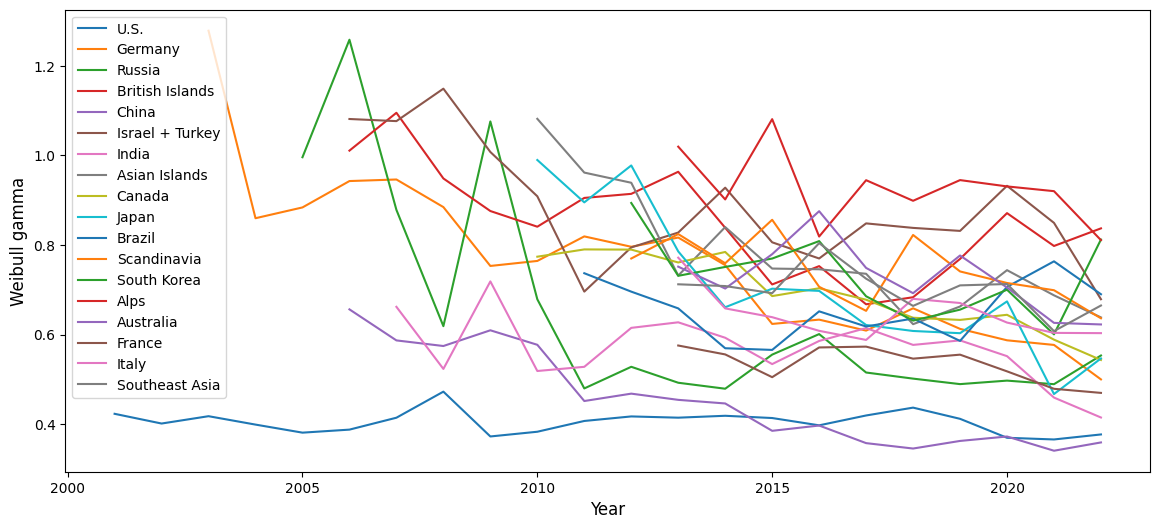

In [25]:
# Plot the Weibull gamma for the different groups in a single line plot over time
fig, ax = plt.subplots(figsize=(14, 6))
coefficient_df.sort_index(inplace=True)
groups = coefficient_df.index.get_level_values('group').unique()
for group in groups:
    data = coefficient_df.xs(group, level='group')['gamma_weibull']
    ax.plot(data.index, data, label=group)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Weibull gamma', fontsize=12)
#ax.set_title('Weibull gamma by group over time')
ax.legend()
plt.show()